In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2, dt=0.001, Re=1.0)

simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['to'])

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

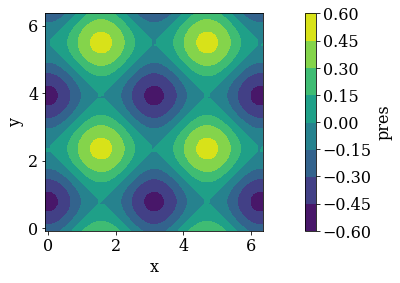

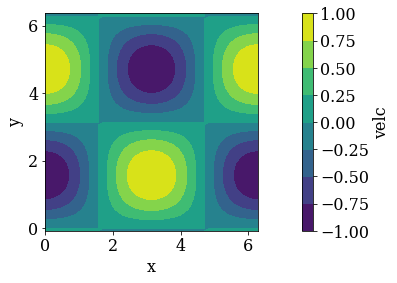

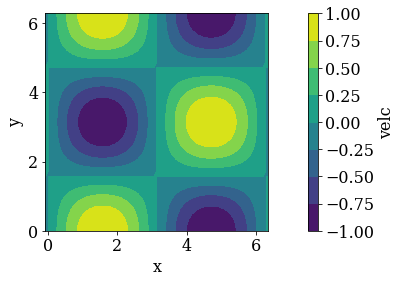

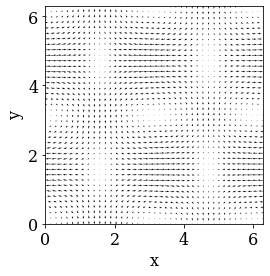

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')


# Start for AB2
# Update the time-dependent boundary condition value
simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])

# Predictor Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

# Divergence Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

# Solve the pressure Poisson equation 
scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                         poisson_options)
# Corrector Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

scalars.advance()

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])
    
    # Predictor Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'predictor')
    
    # Divergence Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                             poisson_options)
    # Corrector Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   
    
    scalars.advance()

------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.902406268998137e-13
Max, Min, U   : 0.9771770479217199, -0.9771770479217198
Max, Min, V   : 0.9771770479217198, -0.9771770479217199
Max, Min, P   : 1.1872759498253058, 0.23902527032103352
Max, Min, DIV : 0.012454254699497319, -0.012454254699497222


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.8570810058287106e-13
Max, Min, U   : 0.9578276459586815, -0.9578276459586814
Max, Min, V   : 0.9578276459586814, -0.9578276459586815
Max, Min, P   : 0.7248222184058881, -0.18596182424419394
Max, Min, DIV : 0.012207643933471124, -0.012207643933471096


------------ Time = 0.03000000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.969013187114945e-13
Max, Min, U   : 0.9388613878252322, -0.9388613878252321
Max, Min, V   : 0.9388613878252321, -0.9388613878252322

------------ Time = 0.3700000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.0994351705825483e-13
Max, Min, U   : 0.47564313254820223, -0.4756431325482022
Max, Min, V   : 0.4756431325482022, -0.47564313254820223
Max, Min, P   : 0.5145525443309469, 0.2896170923694045
Max, Min, DIV : 0.006062136571280345, -0.006062136571280359


------------ Time = 0.3800000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.4366396010970116e-13
Max, Min, U   : 0.466224767491217, -0.46622476749121694
Max, Min, V   : 0.46622476749121694, -0.466224767491217
Max, Min, P   : 0.4511009840413711, 0.23498160865586537
Max, Min, DIV : 0.005942098224573436, -0.005942098224573443


------------ Time = 0.3900000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.846371624452017e-13
Max, Min, U   : 0.45699289855764136, -0.4569928985576413
Max, Min, V   : 0.4569928985576413, -0.45699289855764136


------------ Time = 0.7300000000000005 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.2796855449850875e-14
Max, Min, U   : 0.2316509229701384, -0.23165092297013837
Max, Min, V   : 0.23165092297013837, -0.23165092297013837
Max, Min, P   : 0.06584110586832499, 0.012516560365192277
Max, Min, DIV : 0.002950758652008143, -0.0029507586520080738


------------ Time = 0.7400000000000005 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.3213388801919212e-14
Max, Min, U   : 0.22706840227145564, -0.2270684022714556
Max, Min, V   : 0.2270684022714556, -0.2270684022714556
Max, Min, P   : 0.024479918471907777, -0.02675798634299612
Max, Min, DIV : 0.002892329715946884, -0.0028923297159469327


------------ Time = 0.7500000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.471556375913896e-14
Max, Min, U   : 0.2225765318828794, -0.22257653188287937
Max, Min, V   : 0.22257653188287937, -0.2225765

------------ Time = 1.0899999999999908 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.8117107825577694e-14
Max, Min, U   : 0.11283928639658362, -0.11283928639658362
Max, Min, V   : 0.11283928639658362, -0.11283928639658364
Max, Min, P   : 0.02412559696550141, 0.011438026236180848
Max, Min, DIV : 0.001436288430658214, -0.0014362884306582044


------------ Time = 1.0999999999999897 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.223884870788429e-14
Max, Min, U   : 0.1106073195415669, -0.1106073195415669
Max, Min, V   : 0.1106073195415669, -0.11060731954156691
Max, Min, P   : -0.03672970645671937, -0.0489217796858788
Max, Min, DIV : 0.0014078480142170006, -0.0014078480142169685


------------ Time = 1.1099999999999886 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.1337548778902066e-13
Max, Min, U   : 0.10841951222748858, -0.10841951222748858
Max, Min, V   : 0.10841951222748858, -0.10841

------------ Time = 1.4399999999999522 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.393004038828158e-14
Max, Min, U   : 0.05608099088003031, -0.05608099088003031
Max, Min, V   : 0.05608099088003031, -0.05608099088003031
Max, Min, P   : -0.06746332474332409, -0.07065651024878243
Max, Min, DIV : 0.0007132397266705432, -0.0007132397266705385


------------ Time = 1.449999999999951 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.559777746287623e-14
Max, Min, U   : 0.0549719600930724, -0.05497196009307239
Max, Min, V   : 0.0549719600930724, -0.05497196009307239
Max, Min, P   : -0.045839792275420496, -0.048910803879506366
Max, Min, DIV : 0.0006991166338321426, -0.000699116633832144


------------ Time = 1.45999999999995 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.3633288968798e-14
Max, Min, U   : 0.0538848696304021, -0.05388486963040211
Max, Min, V   : 0.0538848696304021, -0.053884869

------------ Time = 1.7999999999999126 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.0076781885636033e-14
Max, Min, U   : 0.027326497397129418, -0.02732649739712942
Max, Min, V   : 0.02732649739712942, -0.02732649739712942
Max, Min, P   : 0.020494534943809633, 0.019690459641555812
Max, Min, DIV : 0.00034717104599719223, -0.00034717104599720156


------------ Time = 1.8099999999999115 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.984416112878933e-14
Max, Min, U   : 0.026786282488790503, -0.026786282488790506
Max, Min, V   : 0.026786282488790506, -0.026786282488790503
Max, Min, P   : 0.02002723473775914, 0.019252339618278064
Max, Min, DIV : 0.00034029659869696887, -0.0003402965986969704


------------ Time = 1.8199999999999104 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.946404543208867e-15
Max, Min, U   : 0.026256752719164878, -0.026256752719164885
Max, Min, V   : 0.0262567527191

In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.variable['time'])

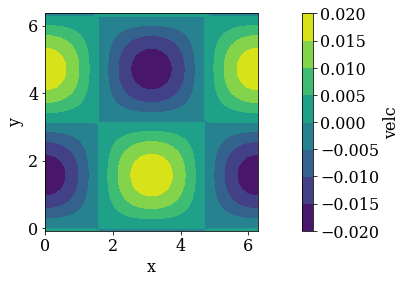

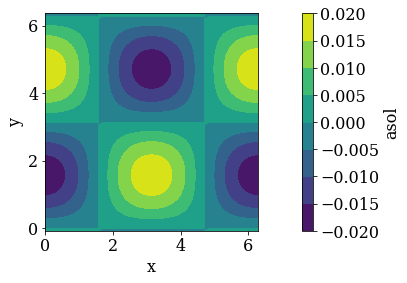

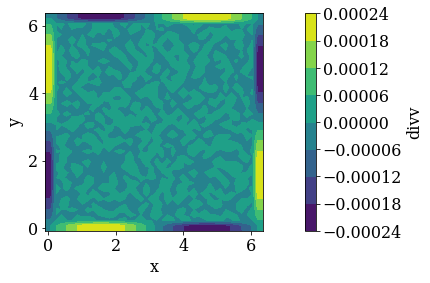

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divv')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

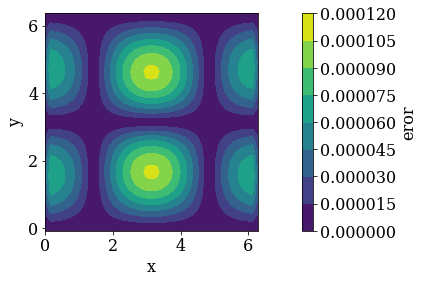

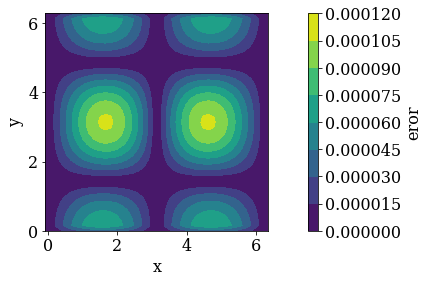

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')